In [1]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr
from sklearn.metrics import f1_score
import scipy
import seaborn as sns


### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.


In [2]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [3]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)
features.head()

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,SEX_Male,RAC1P_Black or African American alone,RAC1P_White alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,True
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


#### 2.1. Pre-processing 
We encoded categorical using the *one-hot encoding*: 
1. For example, column `SEX` is split into two solumns `SEX_Male` and `SEX_Female`. 
2. You can argue that one of this columns is redundant (as when one attribute is equal to 1, the other is equal to 0). 
3. You can extend this line of thougth to a multicategory setting. Let's assume I have a feature with three categories *dog*, *cat* and *monkey* (which are represented using *one-hot encoding*). If both *cat* and *dog* are equal to 0, them *monkey* is equal to 1. In theory, I can drop *monkey* category without loosing any kind of information. 
4. Depending on your task, you might want to keep this columns, but today we are going to assume that those columns are *redundant*. 

In [4]:
# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm'], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


In [5]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

# Subsample for efficiency
N = 20000  # Subsample size

# Generate random unique indices for subsampling
indices_train = np.random.choice(X_train.shape[0], N, replace=False)
indices_test = np.random.choice(X_test.shape[0], N, replace=False)

# Subsample using the random indices
### Train set
X_train = X_train[indices_train]
y_train = y_train[indices_train]
group_train = group_train.iloc[indices_train]
### Test set
X_test = X_test[indices_test]
y_test = y_test[indices_test]
group_test = group_test.iloc[indices_test]
group_test_dict = {
    'Males': group_test['SEX'] == 1,
    'Females': group_test['SEX'] == 2,
    'Whites': group_test['RAC1P'] == 1,
    'African-Americans': group_test['RAC1P'] == 2
}

# Scale all features (even OHE)
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)
n_features = X_train.shape[1]

# Subset for protected and non-protected features
Xs_train_p = Xs_train[:, 54:]
Xs_test_p = Xs_test[:, 54:]
Xs_train_np = Xs_train[:, :54]
Xs_test_np = Xs_test[:, :54]

### 2. Correlations in Data
Let's look at the correlations in our data. For the sake of the time, we are going to assume only *linear interactions* between the features -- and we are just use **Pearson's Correlation Coefficient** (since we have one-hot encoded categorical variables, it is more or less ok to use **Pearson's Correlation** (Thought in your projects, I advice to use more appropriate measures like Cramer's V for categorical-categorical correlation etc. -- [dython](https://shakedzy.xyz/dython/modules/nominal/)).
1. Normilize the continious features, aka first four columns.
2. Use `scipy.stats.pearsonr` to estimate correlations in your data. This function outputs *correlation* and *p-value*. 
3. Use `seaborn.heatmap` to plot correlations (only plot correlations with the significant *p-values*)
4. What features correlate with the protected features?

In [6]:
n_features = X_train.shape[1]
alpha = 0.05 # Significance level
corrected_alpha = alpha / (n_features**2/2) # Bonferroni correction for multiple testings

# Compute correlation matrix
corr = np.zeros((n_features, n_features))
p = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr[i,j], p[i,j] = pearsonr(Xs_train[:,i], Xs_train[:,j])
        if np.isnan(corr[i,j]):
            p[i,j] = 1

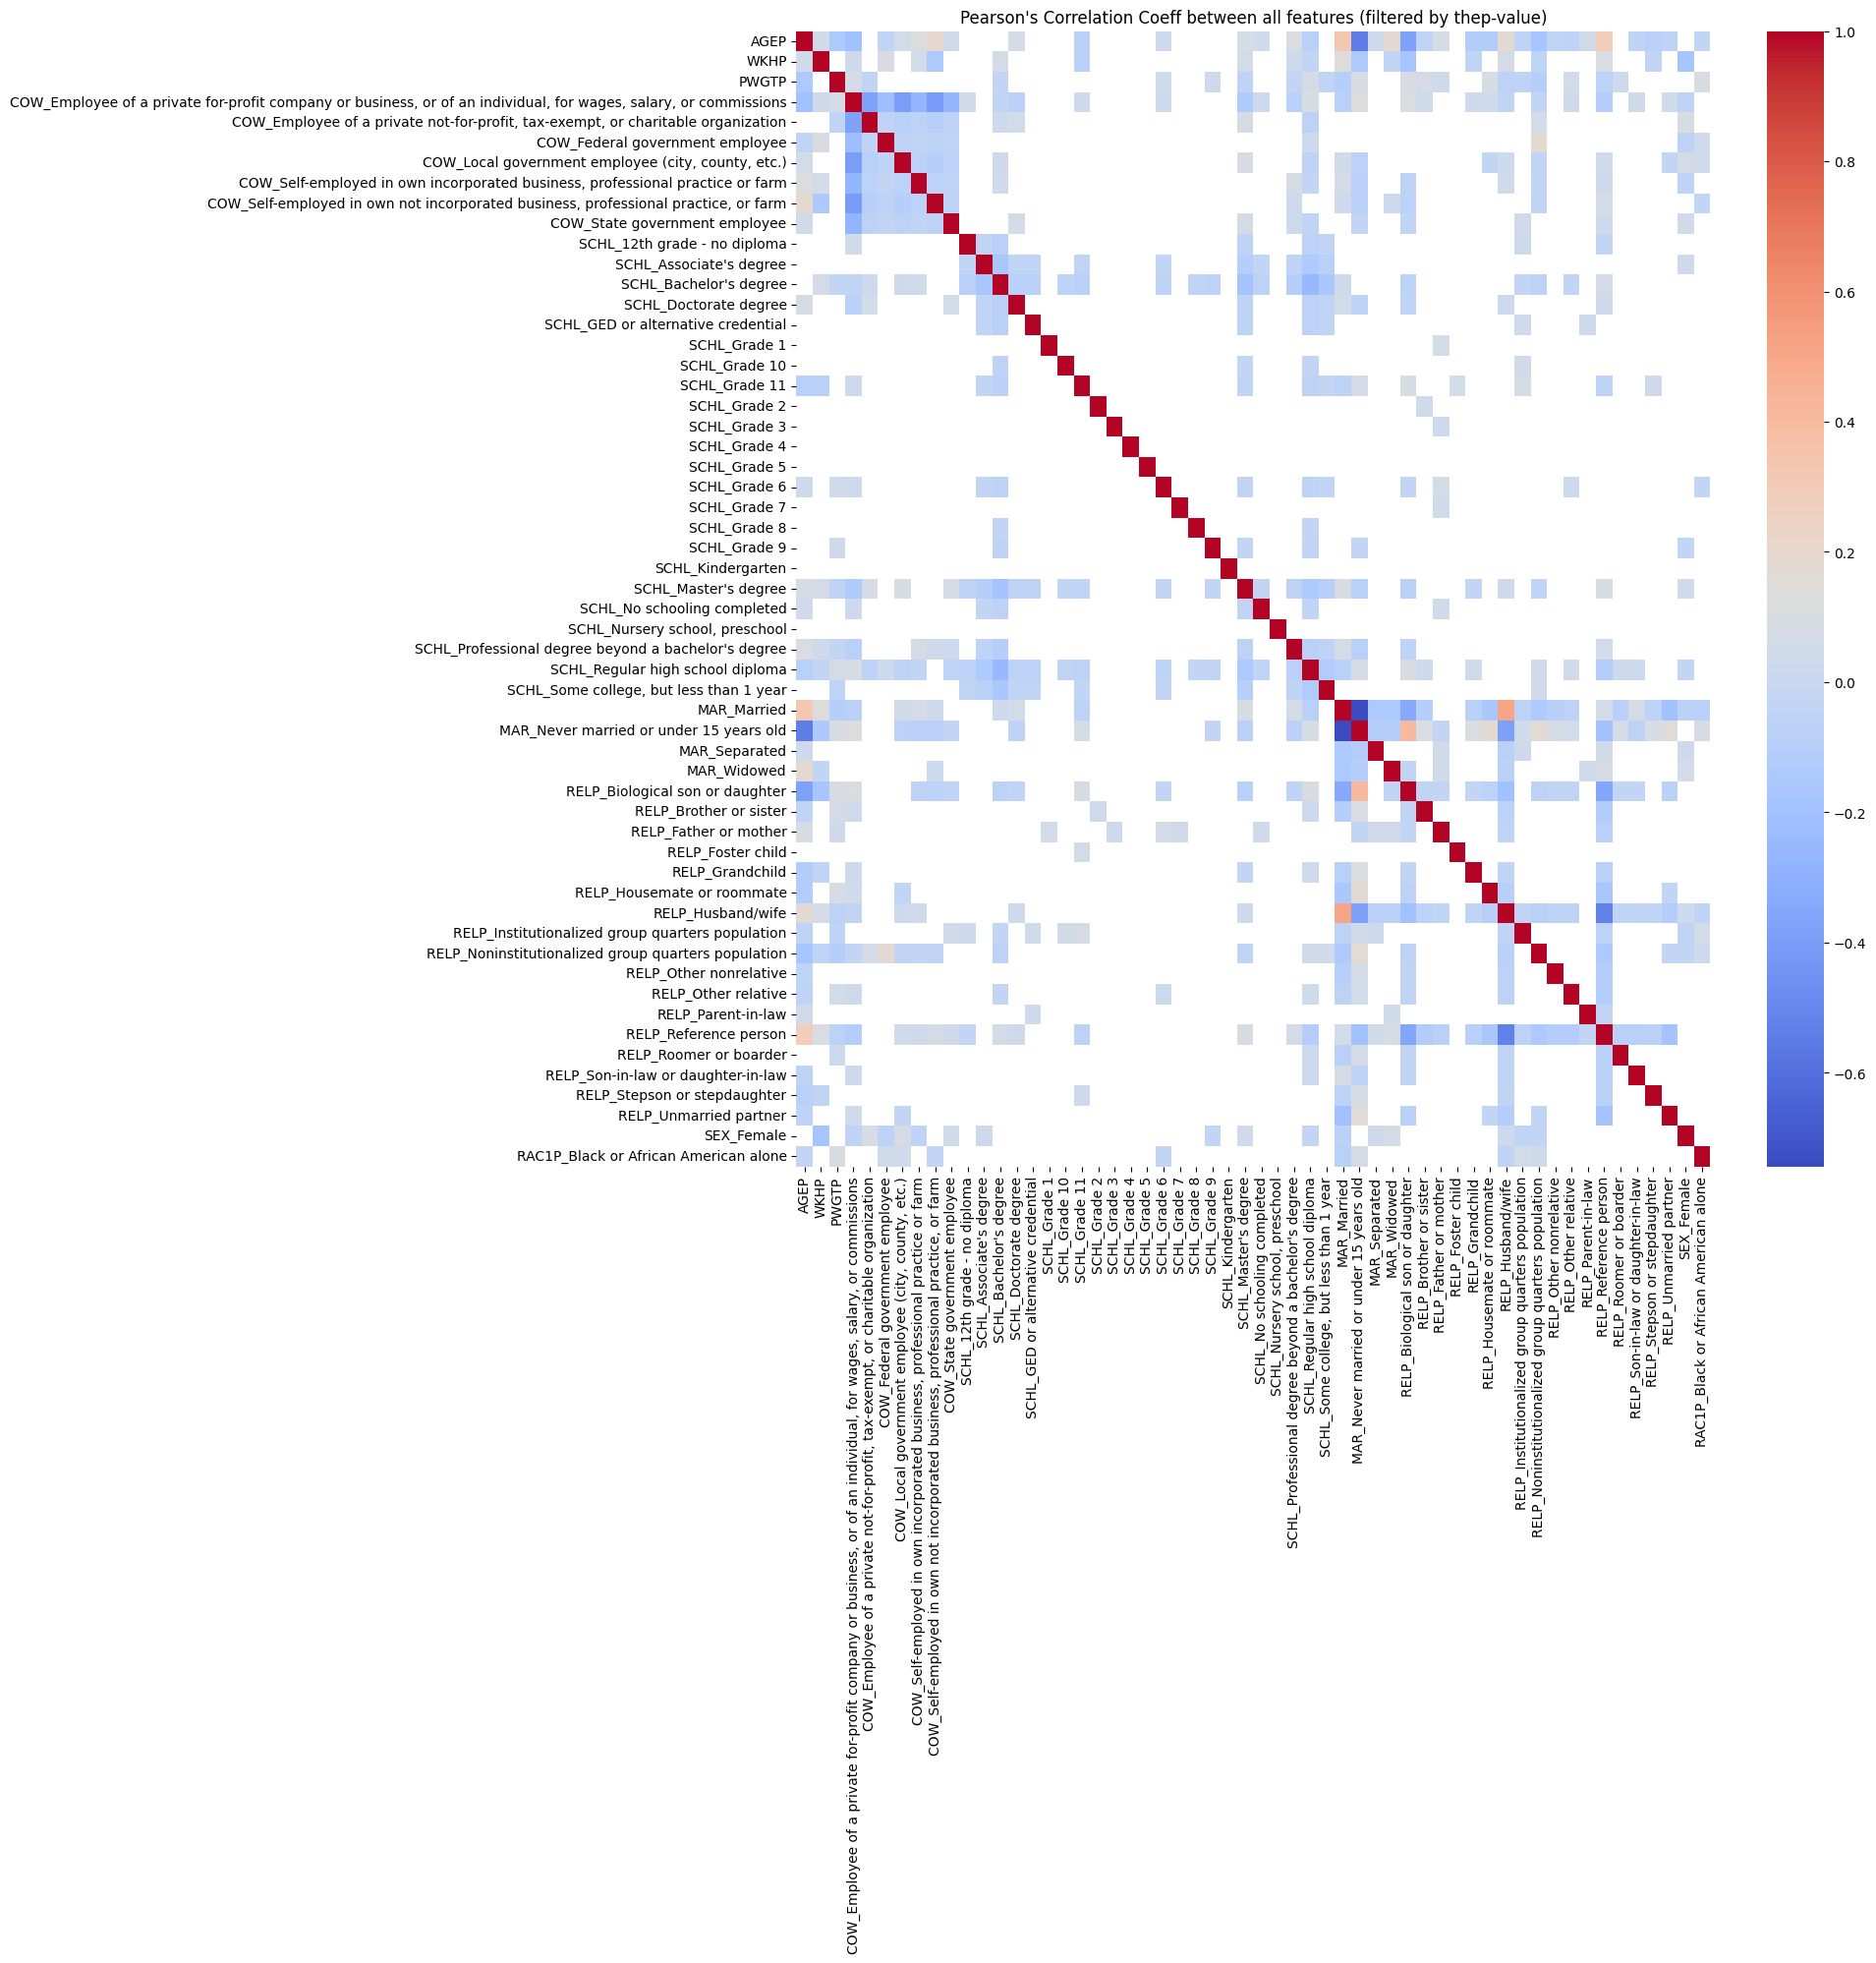

In [7]:
### Visualise full correlarion matrix
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap="coolwarm", xticklabels=features.columns, yticklabels=features.columns, mask= p > corrected_alpha) ## mask if p is higher
plt.title("Pearson's Correlation Coeff between all features (filtered by thep-value)")
plt.show()

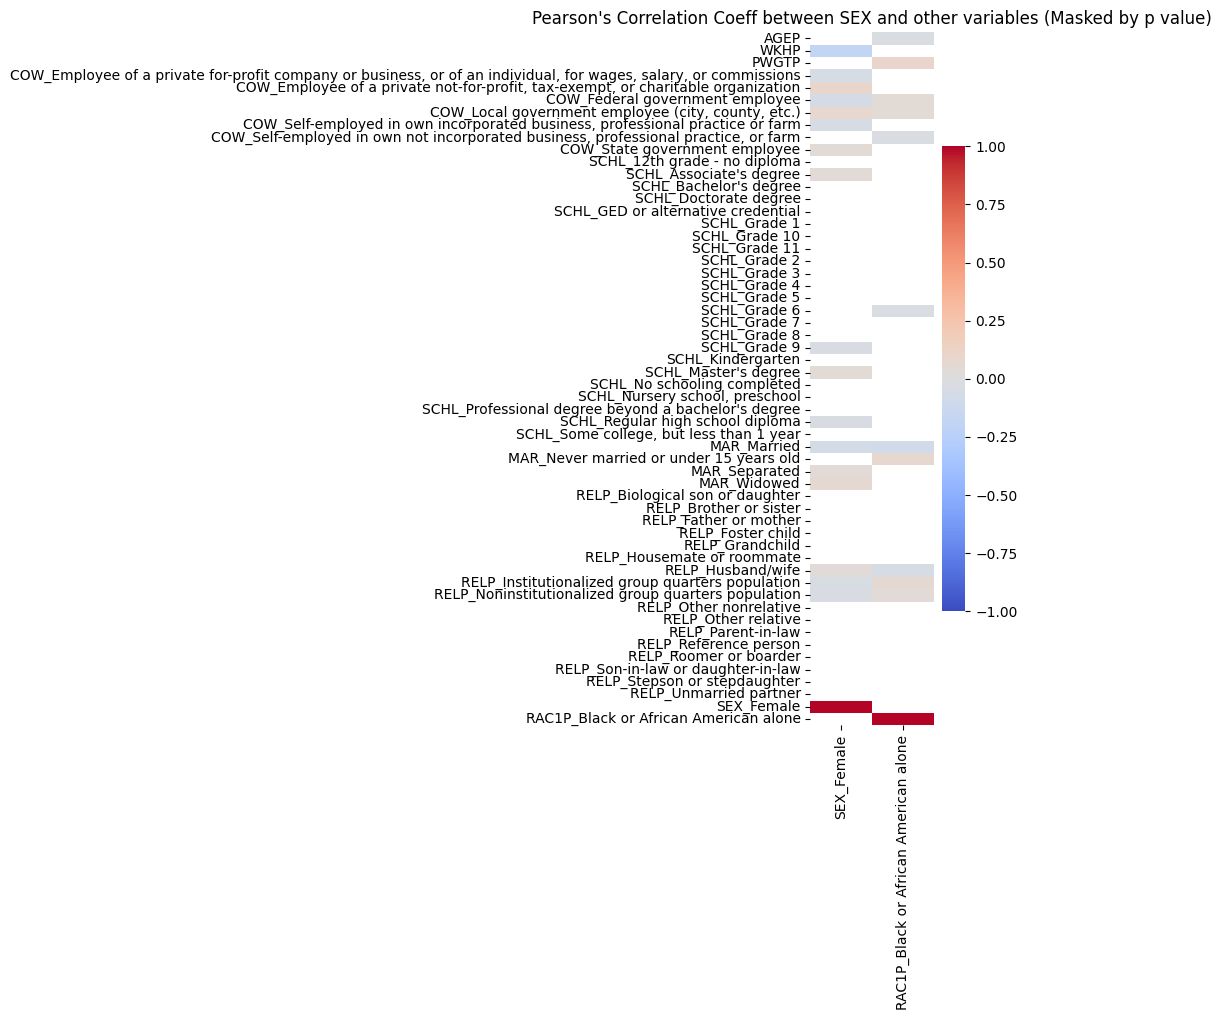

In [8]:
### Visualise columns of the correlation matrix that are associated only with protected features (see Lecture Slides)
plt.figure(figsize=(2,9))
sns.heatmap(corr[:, 54:], cmap="coolwarm", xticklabels=features.columns[54:], yticklabels=features.columns,  mask = p[:, 54:]  > corrected_alpha, vmin=-1, vmax=1)
plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
plt.show()

#### 3. Simple Logistic Regression (by droping the protected attributes)
1. Let's train simple logistic regression (WITHOUT any penalty).
2. Use fairness metric to see how model performs based on the protected feature (you have 2 for `SEX` and 2 groups for `RAC1P`) -- use `group_test`.

In [9]:
# Fit model
model = LogisticRegression(penalty=None, max_iter=1000)
model.fit(Xs_train_np, y_train)
y_hat = model.predict(Xs_test_np)

# Calculate and print F1 Scores for each group
for group, group_idxs in group_test_dict.items():
    print(f'F1, {group}: {f1_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')

# Calculate and print positive rates for each group
for group, group_idxs in group_test_dict.items():
    print(f'Positive Rate, {group}: {np.mean(y_hat[group_idxs]):.2f}')

F1, Males: 0.89
F1, Females: 0.85
F1, Whites: 0.87
F1, African-Americans: 0.83
Positive Rate, Males: 0.77
Positive Rate, Females: 0.73
Positive Rate, Whites: 0.75
Positive Rate, African-Americans: 0.71


#### 4. Fair Representation
We are going to implement the method from [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864): we want to remove protected features from the dataset, plus, remove any existing correlations. This method works only for linearly dependent features (we will use this assumption).
1. Let's split our pre-processed `X_train` into chunks that contain only protected features (aka columns associated with `SEX` and `RAC1P`) and non-protected features.
2. Implement a method that outputs debiased data representation:
    1. Find the orthonormal basis spanned by the column of **protected** features  -- use `scipy.linalg.orth`
    2. Project **non-protected** features onto this basis 
    3. Substract **projected**-features from the original **nonprotected** features (using the penalty of 1)
3. Look at the correlations between **newly aquired non-protected features** and the original protected features. What do you see?
    1. Change the fairness penalty term and describe how it changes the correlation structure in data.
4. Train a logistic regression model (WITHOUT any penalty) with the **newly aquired non-protected** features. 
    1. According to the paper - the coefficients that you obtain should be debiased - so you do not have to change the non-protected features of the test set. 
    2. Use non-protected features of the test set to evaluate the performance of the model (with fairnes penalty of 1) on different protected subgroups. What do you see?

In [10]:
def debias_features(Xs_np, Xs_p):
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = scipy.linalg.orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np - orthbasis @ orthbasis.T @ Xs_np

    # Return debiased nonprotected features
    return Xs_np_debiased

Xs_train_np_debiased = debias_features(Xs_train_np, Xs_train_p)
Xs_train_debiased = np.concatenate([Xs_train_np_debiased, Xs_train_p], axis=1)

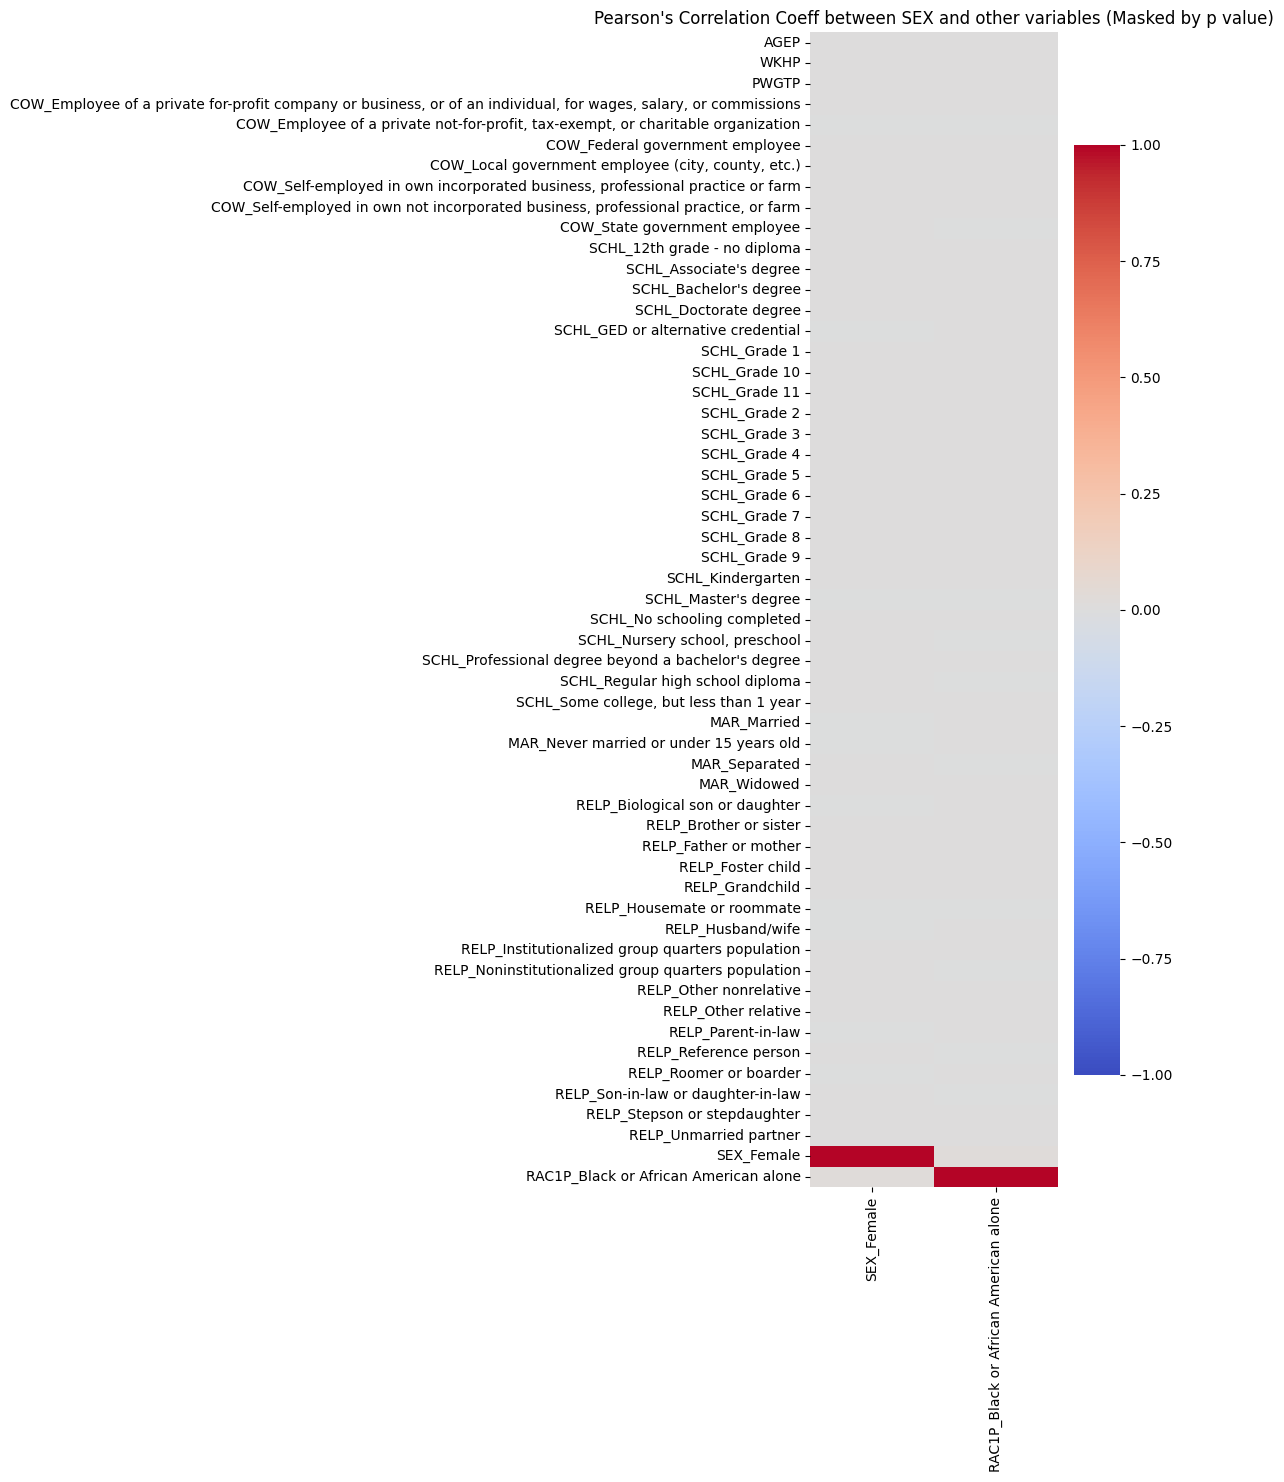

In [11]:
# Compute correlation matrix
n_features = X_train.shape[1]
corr_ = np.zeros((n_features, n_features))
p_ = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_[i,j], p_[i,j] = pearsonr(Xs_train_debiased[:,i], Xs_train_debiased[:,j])
        corr_ = np.nan_to_num(corr_, 0)

# Plot correlations with protected features
plt.figure(figsize=(4,15))
sns.heatmap(corr_[:,54:], cmap="coolwarm", xticklabels=features.columns[54:], yticklabels=features.columns, vmin=-1, vmax=1)
plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
plt.show()

In [12]:
# Fit model
model = LogisticRegression(penalty=None, max_iter=1000)
model.fit(Xs_train_np_debiased, y_train)
y_hat = model.predict(Xs_test_np)

# Calculate and print F1 Scores for each group
for group, group_idxs in group_test_dict.items():
    print(f'F1, {group}: {f1_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')

# Calculate and print positive rates for each group
for group, group_idxs in group_test_dict.items():
    print(f'Positive Rate, {group}: {np.mean(y_hat[group_idxs]):.2f}')

F1, Males: 0.89
F1, Females: 0.84
F1, Whites: 0.87
F1, African-Americans: 0.83
Positive Rate, Males: 0.76
Positive Rate, Females: 0.73
Positive Rate, Whites: 0.75
Positive Rate, African-Americans: 0.71


#### 5. Fair PCA
We are going to implement the method from [Efficient fair PCA for fair representation learning](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning). Here, we will use dimensionality reduction to remove any existing proxies associated with the protected features
1. We are going to work with the pre-processed `X_train` (I'll further refer to it as $X$).
2. Create a matrix $Z$ that contains protected features. **Z = [SEX, RAC1P]**. 
3. Remove mean from each column of $Z$. 
4. Find orthonormal null-space spanned by $\mathbf{Z}^T\mathbf{X}$ - use `scipy.linalg.null_space`. This is our matrix $\mathbf{R}$ (columns are basis vectors).
5. Now we need to find orthonormal eigenvectors of $\mathbf{R}^T\mathbf{X}\mathbf{X}^T\mathbf{R}$ - use `scipy.linalg.eig` (it outputs both eigenvectors and eigenvalues, and eigenvectors are already sorted based on the eigenvalues). Let's used the first 30 eigenvectors. Now we have matrix $\mathbf{L}$ (columns are eigenvectors).
6. Finaly, we can find the projection matrix $\mathbf{U} = \mathbf{R}\mathbf{L}$.
7. Now, we can use $\mathbf{U}$ to project our data into fair space. $\mathbf{X}' = \mathbf{XU}$
8. Let's see if the projected columns of $\mathbf{X}'$ are correlated with columns of $\mathbf{Z}$.
9. Use $\mathbf{X}'$ to train another logistic regression WITHOUT any penalty. 
10. See how does the model performs on different groups (based on the protected features). Don't forget to use projection matrix $\mathbf{U}$ to project `X_test` to fair. dimensions

In [13]:
class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        # Extract protected features
        Xs_p = Xs[:, p_idxs]

        # Compute projection matrix (U)
        Z = Xs_p
        #Z = Z - Z.mean(0) # Since we alredy standardised everything, there is not much sense in removing the mean
        R = scipy.linalg.null_space(Z.T @ Xs)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        return Xs @ self.U
    
fair_pca = FairPCA(Xs_train, [54, 55], 30)
Xs_train_debiased = fair_pca.project(Xs_train)
Xs_test_debiased = fair_pca.project(Xs_test)

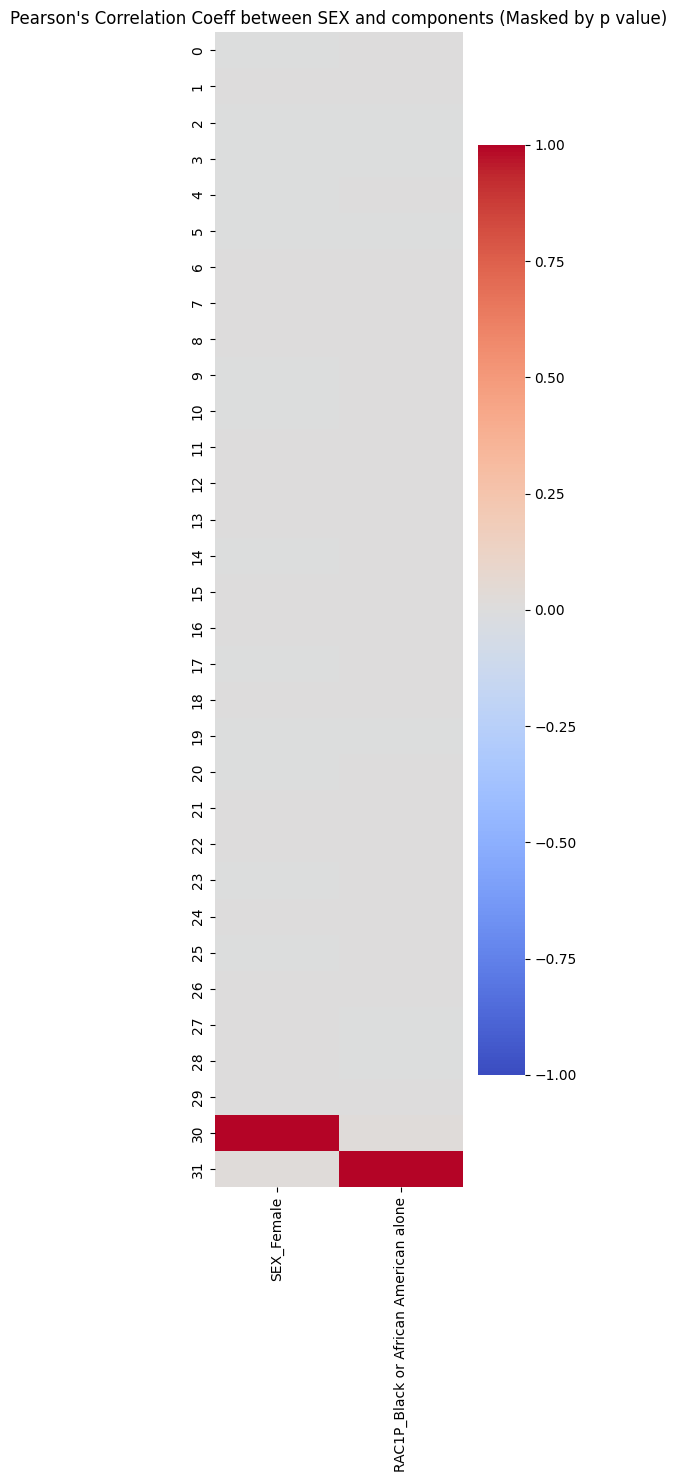

In [14]:
# Compute correlation matrix
Xs_train_debiased_p = np.concatenate([Xs_train_debiased, Xs_train_p], axis=1)
n_features = Xs_train_debiased_p.shape[1]
corr_ = np.zeros((n_features, n_features))
p_ = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_[i,j], p_[i,j] = pearsonr(Xs_train_debiased_p[:,i], Xs_train_debiased_p[:,j])
        corr_ = np.nan_to_num(corr_, 0)

# Plot correlations with protected features
plt.figure(figsize=(4,15))
sns.heatmap(corr_[:,-2:], cmap="coolwarm", xticklabels=features.columns[-2:], vmin=-1, vmax=1)
plt.title("Pearson's Correlation Coeff between SEX and components (Masked by p value)")
plt.show()

In [15]:
# Fit model and predict
model = LogisticRegression(penalty=None, max_iter=1000)
model.fit(Xs_train_debiased, y_train)
y_hat = model.predict(Xs_test_debiased)

# Calculate and print F1 Scores for each group
for group, group_idxs in group_test_dict.items():
    print(f'F1, {group}: {f1_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')

# Calculate and print positive rates for each group
for group, group_idxs in group_test_dict.items():
    print(f'Positive Rate, {group}: {np.mean(y_hat[group_idxs]):.2f}')

F1, Males: 0.89
F1, Females: 0.84
F1, Whites: 0.87
F1, African-Americans: 0.83
Positive Rate, Males: 0.76
Positive Rate, Females: 0.76
Positive Rate, Whites: 0.76
Positive Rate, African-Americans: 0.75
